In [15]:
%matplotlib inline
#load packages
import numpy as np
#from fluid_sphere import *
import time

#set plotting parameters
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.rcParams.update({'font.size': 16})



In [16]:
#define the variables
c_w = 1500 
freqs = np.arange(.1,300,0.1)*1000
f = 200 * 1000
c_b = 1.0025*1500
Range = 10
Radius = 0.003
Rho_w = 1026
Rho_b = 0.66 * Rho_w
#Rho_b = 1.0025 * Rho_w
Theta = 1.571
g = 1.0025
h = 1.0025

#define variable for frequency and length range simulations
freqs_low = np.arange(10,300,0.5)*1000
radii = np.arange(1,20,0.5)/100
fs = np.repeat(freqs_low, len(radii))
rs = np.tile(radii, len(freqs_low))

In [17]:
# -*- coding: utf-8 -*-
'''
:author Sven Gastauer
:licence MIT
'''
## import packages
import numpy as np
import scipy.special as ss

def Lambda(c,f):
    '''
    :param c: Sound velocity (m/s)
    :type  c: float
    
    :param f: acoustic frequency (Hz; s^-1)
    :type  f: int 
    
    return:
    :param lambda: wave length (m)
    :type  lambda: float
    
    desc: Calculates the acoustic wave length (lambda) (m)
    
    defined by SG
    
    status: product
    '''
    return(c/f)


def k(c,f):
    '''
    :param c: Sound velocity (m/s)
    :type  c: float
    
    :param f: acoustic frequency (Hz; s^-1)
    :type  f: int 
    
    return:
    :param lambda: wave length (m)
    :type  lambda: float
    
    desc: Calculates the acoustic wavenumber k
    
    defined by SG
    
    status: product
    '''
    return(2 * np.pi / Lambda(c,f))


def legendreP(Degree,Coeffs):
    '''
    desc: Compute the Legendre Polynomial using the reccurence relation in numerical recipes in C (Eq. 4.6.10) but with j = j-1 i.e. P_j = (2j -1)xP_(j-1) - (j-1)P_(j-2) to be evaluated at point x with P_0 = 1, P_1 = x
    
    :param Degree: scalar defining the degree of the desired polynomial
    :type Degree: float
    
    :param Coeffs: values at which the polynomial will be evaluated
    :type Coeffs: float
    '''
    LegPoly = np.ones(Coeffs.size)
    #for degree = 0 all legendre polynomials are = 1 so don't do anything.
    if Degree > 0:
        LegPoly_p1 = Coeffs * LegPoly 
        if Degree == 1:
            LegPoly = LegPoly_p1 #case for P_1 = x
        else:
            #apply recurrsive formula up to desired Degree
            for Cntr in range(2, Degree):
                LegPoly_p2 = (Coeffs * ( 2 * Cntr - 1) * LegPoly_p1 - (Cntr - 1) * LegPoly ) / Cntr
                LegPoly = LegPoly_p1
                LegPoly_p1 = LegPoly_p2
                LegPoly = LegPoly_p2;
    return LegPoly


'''
:desc Computes an analytical solution for the scattered pressure from an incident plane wave impinging upon a fluid sphere following
 Anderson, V. C., "Sound scattering from a fluid sphere", 
 J. Acoust. Soc. America, 22 (4), pp 426-431, July 1950
:param c_w: Sound velocity external fluid (m/s)
:type c_w: float
:param f: acoustic frequency (Hz; s^-1)
:type f: int
:param c_b: Sound verlocity inside the scattering body (m/s)
:type c_b: float
:param range: DIstance to the center of the sphere (m)
:type range: float
:param radius: Radius of the scattering sphere (m)
:type radius: float
:param Rho_w: Density of the surrounding fluid medium (kg m^-3)
:type Rho_w: float
:param Rho_b: Density of the scattering body (kg m^-3)
:type Rho_b: float
:param Theta: scattering angle relative to the travelling direction of the \
incident wave (rad) for backscatter: 90degrees × pi/180 = 1,571 rad
:type Theta: float
'''
def fluid_sphere(f,Radius, Range, Rho_w,Rho_b,Theta,c_w,c_b):
    #compute wavelength and wave number in the external fluid
    K_ext = k(c_w,f) # wave number
    
    #compute wavenumber inside the scattering body
    K_int = k(c_b, f)
    
    #set convergence parameters
    ConvLim = 1e-10
    MaxCount = 200
    
    #wavenumbers
    kr = K_ext * Range #wavenumber at range
    ka = K_ext * Radius #wvenumber radius
    kdasha = K_int * Radius #wavenumber radius inside
    
    #density and soundspeed contrasts
    g = Rho_b / Rho_w #density contrast
    h = c_b / c_w #sound velocity contrast
    rho_c = Rho_w * c_w 
    
    #check for convergence and set starting parameters
    Done = False
    Count = 0
    m = 0
    while Done == False:
        # build vector of theta angles and ranges inside/outside of sphere
        #Theta = np.arange(0.0,np.pi,np.pi/180)
        CosTheta = np.cos(Theta)
        #Ext_Range = np.arange(1.5 * Radius, Radius, -0.5 * Radius / 20)
        #Int_Range = np.arange(Radius,0,-Radius/40)
            
        ###compute spherical bessel fucntions with ka, k'a, kr, k'r
        ###use functions from scipy.special
        
        #Bessel functions first degree
        Jm_kr = ss.spherical_jn(m, kr)
        Jm_ka = ss.spherical_jn(m, ka)
        Jm_kdasha = ss.spherical_jn(m, kdasha)
        
        #bessel functions second degree
        Nm_Kr = ss.spherical_yn(m, kr)
        Nm_Ka = ss.spherical_yn(m, ka)
        
        #First degree derivate bessel functions
        Alpham_kdasha = (2 * m + 1) * ss.spherical_jn(m, kdasha, derivative=True)
        Alpham_ka = (2 * m + 1) * ss.spherical_jn(m, ka, derivative=True)
        Alpham_kr = (2 * m + 1) * ss.spherical_jn(m, kr, derivative=True)
        
        #Second degree derivate bessel functions
        Betam_ka = (2 * m + 1) * ss.spherical_yn(m, ka, derivative=True)
        Betam_kr = (2 * m + 1) * ss.spherical_yn(m, kr, derivative=True)
        
        
        # Compute Legendre Polynom, dependent on Theta
        Pm = legendreP(m, CosTheta)
        
        # Calculate Cm for the current m value - independant of theta
        Cm = (( Alpham_kdasha / Alpham_ka) * (Nm_Ka / Jm_kdasha) - \
              (Betam_ka / Alpham_ka) * g * h) / ((Alpham_kdasha / Alpham_ka) * \
              (Jm_ka / Jm_kdasha) - g * h)
        
        # Use Cm coefficient to calculate Am explcitely and then Bm from this
        Am = -( (-1j)**m) * (2 * m + 1) / (1 + 1j * Cm)
           
        # Now use Cm to calculate current 'm' value scattered pressure contribution
        ThisPs = -(((-1j)**m) * (2 * m + 1) / (1 + 1j * Cm)) * Pm * \
                   (Jm_kr + 1j * Nm_Kr)
        ThisPi = ((-1j)**m) * (2 * m + 1) * Pm * Jm_kr
        ThisTS = ((-1)**m) * (2 * m + 1) / (1 + 1j * Cm)
        
        # exterior domain particle velocity
        ThisVel = (-1j / rho_c) * (Am / (2 * m + 1)) * Pm * (Alpham_kr +\
                  1j * Betam_kr)
        ThisVel_Inc = (-1j / rho_c) * ((-1j)**m) * Pm * Alpham_kr
        if m == 0:
            Ps = ThisPs
            Pi = ThisPi
            TS = ThisTS
            Vel = ThisVel
            Vel_Inc = ThisVel_Inc
        else:
            Ps = Ps + ThisPs
            Pi = Pi + ThisPi
            TS = TS + ThisTS
            Vel = Vel + ThisVel
            Vel_Inc = Vel_Inc + ThisVel_Inc
        m += 1
        Count += 1
        if max(abs(ThisPs)) < ConvLim and m > 10:
              Done = True;
        elif Count > MaxCount:
              Done = True
              print('Convergence failure in FluidSphereScat')
        
        IsBad = np.isnan(Ps)
        Ps[IsBad] = 0
        
    #Calculate final TS after summation is complete
    TS = (2 / ka)**2 * abs(TS)**2 * (np.pi * Radius * Radius)
    TS = 10 * np.log10(TS / ( 4 * np.pi))
    
    #print('Backscatter TS of the sphere is %.2f dB re 1m^2'%TS)
    return(TS)

'''
:desc Simplified analytical TS for a fluid sphere following Jehc et al 2015, modified from
 Anderson, V. C., "Sound scattering from a fluid sphere", 
 J. Acoust. Soc. America, 22 (4), pp 426-431, July 1950
:param c: Sound velocity external fluid (m/s)
:type c: float
:param f: acoustic frequency (Hz; s^-1)
:type f: int
:param h: Sound verlocity contrast
:type c_b: float
:param r: DIstance to the center of the sphere (m)
:type r: float
:param a: Radius of the scattering sphere (m)
:type a: float
:param g: Density contrast
:type g: float
'''

def fluid_sphere_simple(f,r,a,c,h,g):
    #External fluid
    k0 = k(c,f) #Wavenumber surrounding fluid
    ka = k0 * a #Wavenumber surrounding fluid * radius
    
    #Internal fluid
    k1 = k(h*c,f) #Wavenumber internal fluid
    k1a = k1 * a  #Wavenumber internal fluid * radius
    #rho1 <- g *rho #density internal fluid
    Cn_fun = lambda x:((ss.spherical_jn(x, k1a, derivative=True) * ss.spherical_yn(x, ka))\
                       /(ss.spherical_jn(x,k1a) * ss.spherical_jn(x,ka,  derivative=True))\
                       - g * h * (ss.spherical_yn(x,ka, derivative=True) \
                                  / ss.spherical_jn(x,ka, derivative=True))) \
                       /((ss.spherical_jn(x,k1a, derivative=True) * ss.spherical_jn(x,ka))\
                         /(ss.spherical_jn(x,k1a) * ss.spherical_jn(x,ka, derivative=True))\
                         - g * h)
    n = np.arange(0,round(ka+20,0)).astype(int)
    Cn = list(map(Cn_fun,n))
    A = -1 / (1 + 1j * np.asarray(Cn))
    fbs = -1j / k0 * np.sum((-1)**n * (2*n +1) * A)
    TS = 10 * np.log10(abs(fbs)**2)
    return(TS)

'''
    desc: Spherical Hankel Function
    :param n: Order
    :type n: float
    
    :param z: Argument of the Bessel/Hankel function
    :type z: float
'''
def sphericalHankel(n,z):
    hn_real = np.sqrt(np.pi / (2 * z)) *ss.jv(n + 0.5,z)
    hn_imag = np.sqrt(np.pi / (2 * z)) * ss.yv(n + 0.5,z)
    hn = hn_real +  hn_imag * 1j
    return(hn)
    
'''
    desc: Derivate of the First Order Spherical Hankel Function
    :param n: Order
    :type n: float
    
    :param z: Argument of the Bessel/Hankel function
    :type z: float
'''
    
def sphericalHankel_deriv(n, z):
    if n == 0:
        Hankel_n = (np.sqrt((np.pi) / (2 * z ))) * ss.jv(n+1/2, z)+\
        1j * (np.sqrt ( np.pi / (2 * z ))) * ss.yv(n + 1 / 2, z)
        Hankel_nplus1 = (np.sqrt(np.pi / ( 2 * z))) * ss.jv(n + 3 / 2, z) +\
        1j * (np.sqrt ( np.pi / (2 * z ))) * ss.yv(n + 3 / 2,z)
        return((n / z) * Hankel_n - Hankel_nplus1)
    elif n > 0:
        Hankel_n = (np.sqrt(np.pi / (2 * n))) * ss.jv(n + 1 / 2, z)+ \
        1j * (np.sqrt(np.pi / ( 2 * z))) * ss.yv(n + 1 / 2 , z)    
        Hankel_ntake1 = (np.sqrt( np.pi / (2 * z))) * ss.jv(n - 1 / 2,z) +\
        1j * (np.sqrt(np.pi / (2 * z))) * ss.yv(n - 1 / 2, z)
        return(Hankel_ntake1 - ((n + 1) / z) * Hankel_n)

'''
:desc Simplified analytical TS for a pressure release sphere following Jech et al 2015, modified from
 Anderson, V. C., "Sound scattering from a fluid sphere", 
 J. Acoust. Soc. America, 22 (4), pp 426-431, July 1950
:param c: Sound velocity external fluid (m/s)
:type c: float
:param f: acoustic frequency (Hz; s^-1)
:type f: int
:param a: Radius of the scattering sphere (m)
:type a: float
'''
def pressure_release_sphere_simple(f,a,c):
    #External fluid
    k0 = k(c,f) #Wavenumber surrounding fluid
    ka = k0 * a #Wavenumber surrounding fluid * radius
    
    n = np.arange(0,round(ka+20,0)).astype(int)
    A_fun = lambda x: - ss.spherical_jn(x,ka) / sphericalHankel(x,ka)
    A = list(map(A_fun,n))
    fbs = -1j / k0 * np.sum((-1)**n * (2*n +1) * A)
    TS = 10 * np.log10(abs(fbs)**2)
    return(TS)     

'''
:desc Simplified analytical TS for a rigid sphere following Jech et al 2015, modified from
 Anderson, V. C., "Sound scattering from a fluid sphere", 
 J. Acoust. Soc. America, 22 (4), pp 426-431, July 1950
:param c: Sound velocity external fluid (m/s)
:type c: float
:param f: acoustic frequency (Hz; s^-1)
:type f: int
:param a: Radius of the scattering sphere (m)
:type a: float
'''
def rigid_sphere_simple(f,a,c):
    #External fluid
    k0 = k(c,f) #Wavenumber surrounding fluid
    ka = k0 * a #Wavenumber surrounding fluid * radius
    n = np.arange(0,round(ka+20,0)).astype(int)
    A_fun = lambda x: - ss.spherical_jn(x, ka, derivative = True) / \
    sphericalHankel_deriv(x, ka)
    A = list(map(A_fun,n))
    fbs = -1j / k0 * np.sum((-1)**n * (2*n +1) * A)
    TS = 10 * np.log10(abs(fbs)**2)
    return(TS)     

    '''© 2021 GitHub, Inc.
    Terms
    Privacy
    Security
    Status
    Docs'''



In [18]:
#Run the TS simulations

#single frequency
start = time.perf_counter()
TS_py = fluid_sphere(f=f,Radius=Radius, Range=Range,Rho_w=Rho_w,Rho_b=Rho_b,Theta=Theta,c_w=c_w,c_b=c_b)
end = time.perf_counter()
tel_s0 = end - start

TS Anderson (1950) - Evaluating the TS took 4.15 seconds for 2999 simulations
TS Jech et al.(2015) - Evaluating the TS took 2.94 seconds for 2999 simulations


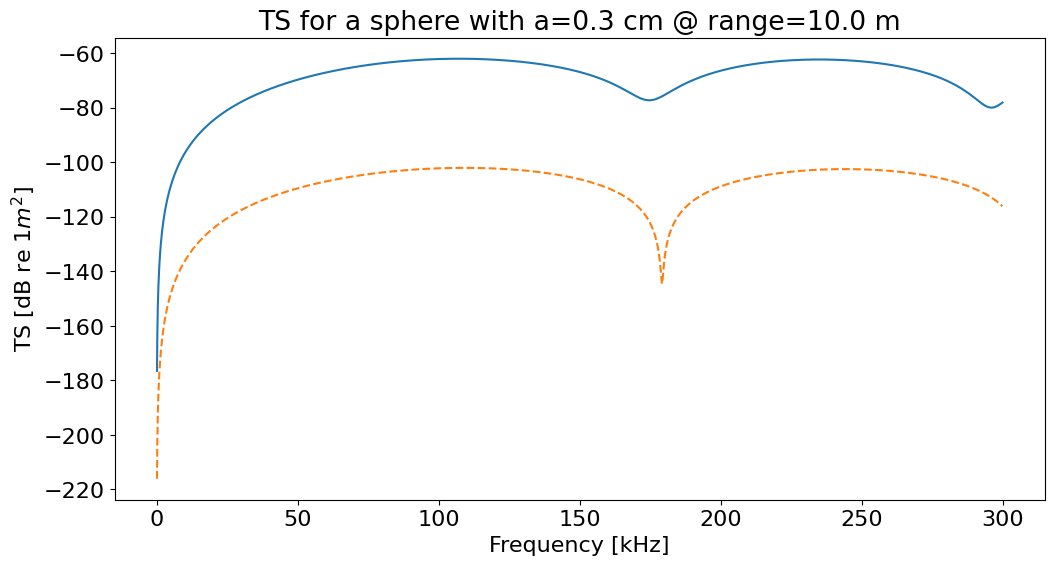

In [19]:
#frequency range
start = time.perf_counter()
TS_py = [fluid_sphere(f=x,Radius=Radius, Range=Range,Rho_w=Rho_w,Rho_b=Rho_b,Theta=Theta,c_w=c_w,c_b=c_b) for x in freqs]
end = time.perf_counter()
tel_0 = end - start
print("TS Anderson (1950) - Evaluating the TS took %.2f seconds for %i simulations"%(tel_0, len(TS_py)))

#Run the TS simulations for the simplified model

#single frequency
start = time.perf_counter()
TS_py_sim = fluid_sphere_simple(f=f,r=Range,a=Radius,c=c_w,h=h,g=g)#,rho=Rho_w)
#(f,r,a,c,h,g)
end = time.perf_counter()
tel_s1 = end - start

#frequency range
start = time.perf_counter()
#TS_py_sim = [fluid_sphere_simple(f=x,r=Range,a=Radius,c=c_w,h=h,g=g,rho=Rho_w) for x in freqs]
TS_py_sim = [fluid_sphere_simple(f=x,r=Range,a=Radius,c=c_w,h=h,g=g) for x in freqs]
end = time.perf_counter()
tel_1 = end - start
print("TS Jech et al.(2015) - Evaluating the TS took %.2f seconds for %i simulations"%(tel_1, len(TS_py_sim)))

#generate plot with matplotlib
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(freqs/1000, TS_py)
ax.plot(freqs/1000, TS_py_sim, "--")
plt.xlabel("Frequency [kHz]")
plt.ylabel("TS [dB re 1$m^2$]")
plt.title("TS for a sphere with a=%.1f cm @ range=%.1f m"%(Radius*100,Range))
plt.show()

TS Anderson (1950) - Evaluating the TS took 3.99 seconds for 2999 simulations
TS Jech et al.(2015) - Evaluating the TS took 2.70 seconds for 2999 simulations


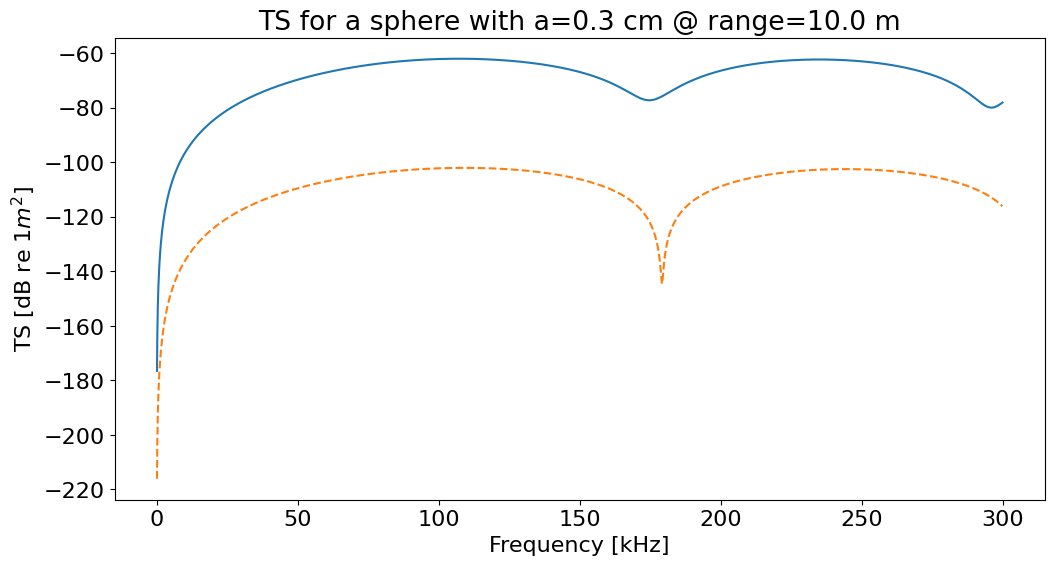

In [20]:
#set plotting parameters
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

#Run the TS simulations

#single frequency
start = time.perf_counter()
TS_py = fluid_sphere(f=f,Radius=Radius, Range=Range,Rho_w=Rho_w,Rho_b=Rho_b,Theta=Theta,c_w=c_w,c_b=c_b)
end = time.perf_counter()
tel_s0 = end - start

#frequency range
start = time.perf_counter()
TS_py = [fluid_sphere(f=x,Radius=Radius, Range=Range,Rho_w=Rho_w,Rho_b=Rho_b,Theta=Theta,c_w=c_w,c_b=c_b) for x in freqs]
end = time.perf_counter()
tel_0 = end - start
print("TS Anderson (1950) - Evaluating the TS took %.2f seconds for %i simulations"%(tel_0, len(TS_py)))

#Run the TS simulations for the simplified model

#single frequency
start = time.perf_counter()
TS_py_sim = fluid_sphere_simple(f=f,r=Range,a=Radius,c=c_w,h=h,g=g)
end = time.perf_counter()
tel_s1 = end - start

#frequency range
start = time.perf_counter()
TS_py_sim = [fluid_sphere_simple(f=x,r=Range,a=Radius,c=c_w,h=h,g=g) for x in freqs]
end = time.perf_counter()
tel_1 = end - start
print("TS Jech et al.(2015) - Evaluating the TS took %.2f seconds for %i simulations"%(tel_1, len(TS_py_sim)))

#generate plot with matplotlib
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(freqs/1000, TS_py)
ax.plot(freqs/1000, TS_py_sim, "--")
plt.xlabel("Frequency [kHz]")
plt.ylabel("TS [dB re 1$m^2$]")
plt.title("TS for a sphere with a=%.1f cm @ range=%.1f m"%(Radius*100,Range))
plt.show()

Evaluating the TS took 91.67 seconds for 22040 simulations


/tmp/ipykernel_27724/1991083372.py:14: FutureWarning: The provided callable <function median at 0x7f8458021120> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df = dataset.pivot_table(index='Radius', columns='Frequency', values='TS', aggfunc=np.median)


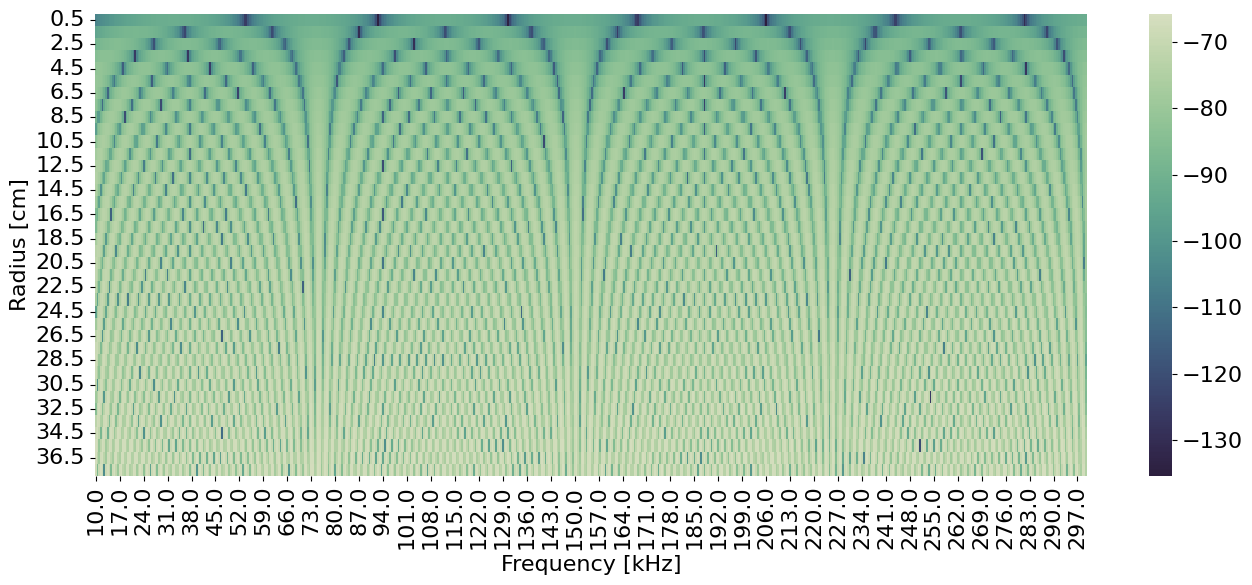

In [21]:
# create function with fixed a, c, h and g but variable f and r
def ts_map(x,y):
    return(fluid_sphere_simple(f=x,r=Range,a=y,c=c_w,h=h,g=g))

start = time.perf_counter()    
#vertorise and simulate
tsmap = np.vectorize(ts_map)(fs, rs)
end = time.perf_counter()
tel_sim = end - start
print("Evaluating the TS took %.2f seconds for %i simulations"%(tel_sim, len(tsmap)))

#create pandas dataframe
dataset = pd.DataFrame({'Frequency':fs/1000,'Radius':rs*100,'TS':tsmap})
df = dataset.pivot_table(index='Radius', columns='Frequency', values='TS', aggfunc=np.median)

# create heatmap
plt.figure(figsize=(16, 6))
p =sns.heatmap(df, annot=False, 
               cmap=sns.cubehelix_palette(8, start=.5, rot=-.75, reverse=True, as_cmap=True))
ylabels = ['{:,.1f}'.format(x) for x in p.get_yticks()]
p.set_yticklabels(ylabels)
p.set(xlabel='Frequency [kHz]', ylabel='Radius [cm]')
plt.show()